# Урок 6. Градиентный бустинг

### 1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

In [3]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [4]:
def bias(y, z):
    return (y - z)

In [5]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=5)

        if len(trees) == 0:
            tree.fit(X_train, y_train)
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))

        train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
        
    return trees, train_errors, test_errors

In [20]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta):
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    train_err = mean_squared_error(y_train, train_prediction)

#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, coefs, eta)
    test_err = mean_squared_error(y_test, test_prediction)

#     print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
#     с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')
    return train_err, test_err

In [7]:
def err_plot(n_trees, max_depth, eta, train_err, test_err, axes_counter):
    iterations = list(range(n_trees))
    axi = ax.flatten()[axes_counter]
    axi.set_xlabel('Iteration number')
    axi.set_ylabel('MSE')
    axi.set_xlim(0, n_trees)
    axi.plot(iterations, train_err, label='train error')
    axi.plot(iterations, test_err, label='test error')
    axi.legend(loc='upper right')
    axi.set_title(f'{axes_counter}. Trees: {n_trees}, depth: {max_depth}, eta: {eta}')

In [8]:
X, y = load_diabetes(return_X_y=True)

In [9]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [38]:
params = {
    'n_trees': [10, 20, 30, 40],
    'max_depth': [2, 4, 6, 8],
    'eta': [0.5, 0.1, 0.05]
}

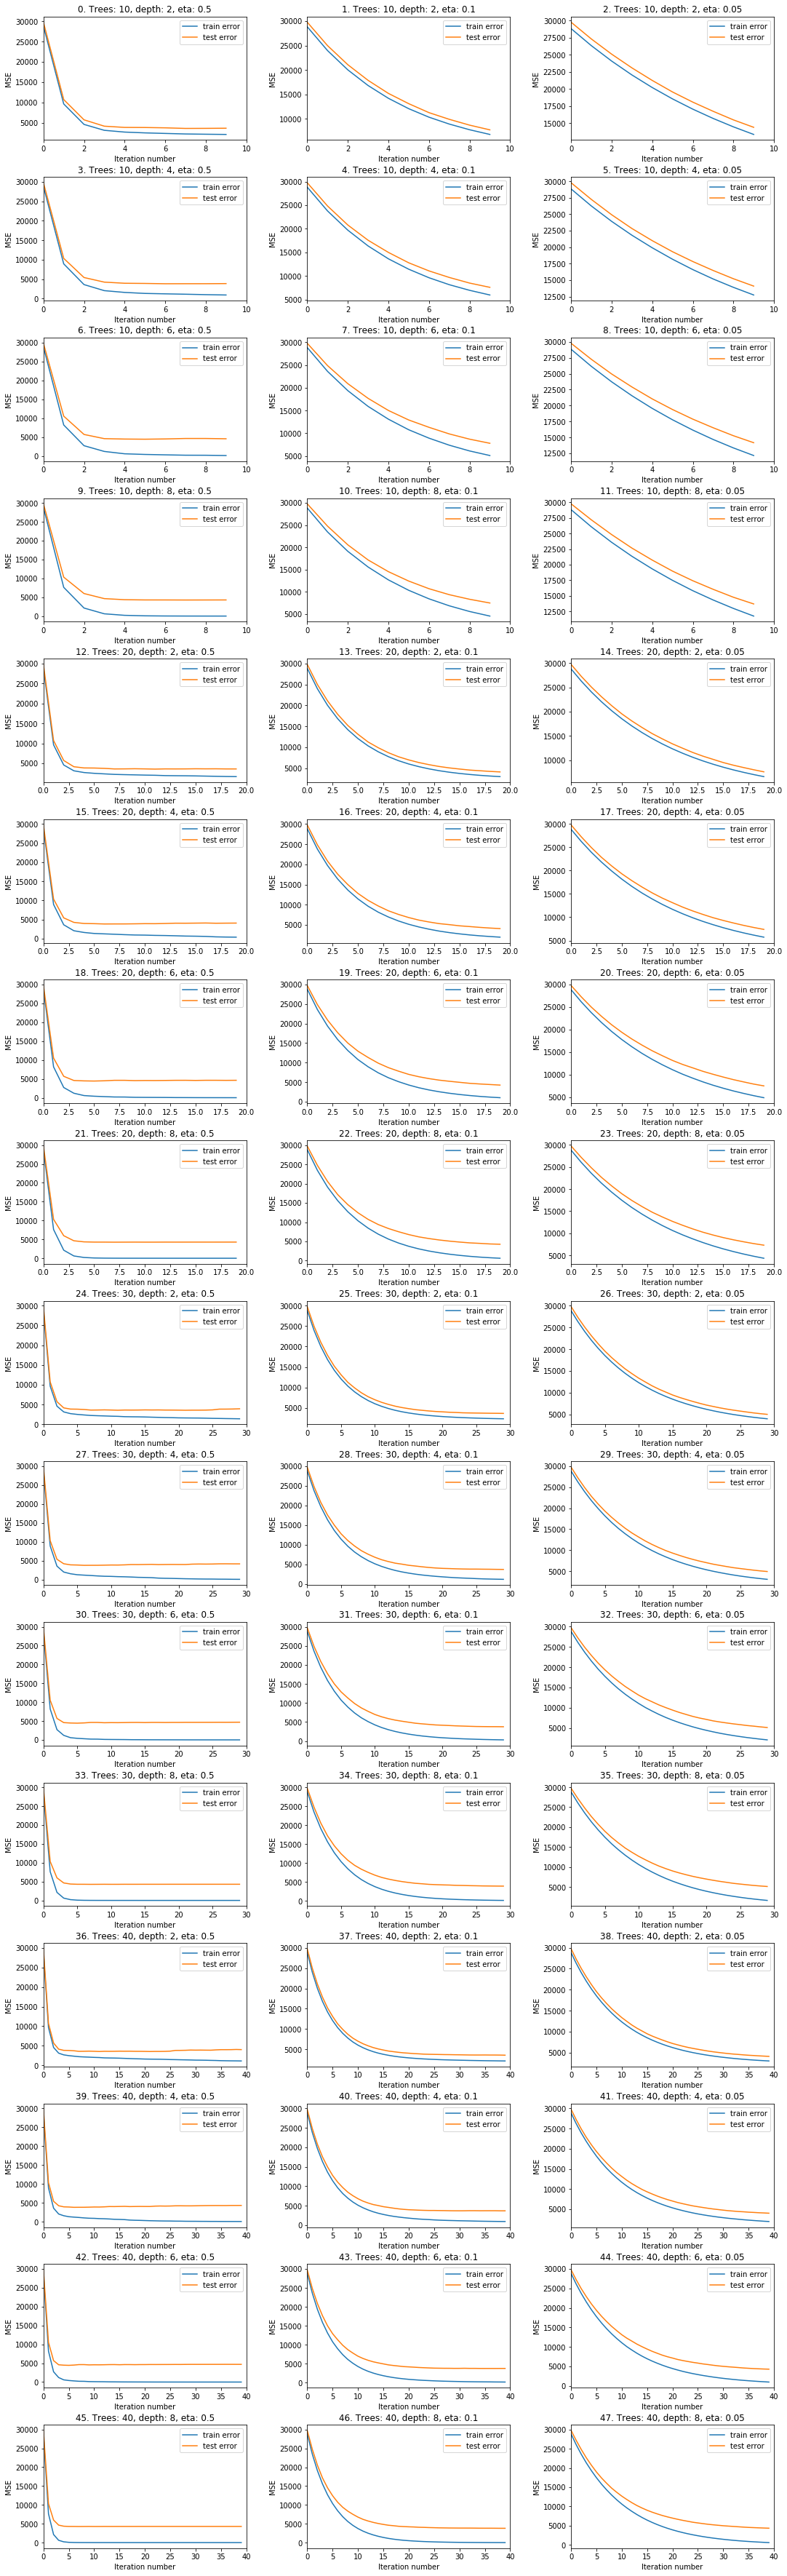

In [39]:
ncols = 3
nrows = (np.prod([len(params[i]) for i in params])) // ncols

fig, ax = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(18, 4 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

errors = []
axes_counter = 0

for n_trees in params['n_trees']:
    coefs = [1] * n_trees
    for max_depth in params['max_depth']:
        for eta in params['eta']:
            trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
            train_err, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)

            errors.append([n_trees, max_depth, eta, train_err, test_err])

            err_plot(n_trees, max_depth, eta, train_errors, test_errors, axes_counter)

            axes_counter +=1

In [59]:
df = pd.DataFrame(errors, columns = ['n_trees', 'max_depth', 'eta', 'train_err', 'test_err'])
df[:10]

,n_trees,max_depth,eta,train_err,test_err
0,10,2,0.50,2054.596665,3607.401265
1,10,2,0.10,6038.960518,7013.308611
2,10,2,0.05,12330.833966,13359.443666
3,10,4,0.50,893.061233,3897.515007
4,10,4,0.10,5149.297559,6817.842007
5,10,4,0.05,11692.504091,13115.036336
6,10,6,0.50,103.223971,4579.662058
7,10,6,0.10,4260.249476,6984.909418
8,10,6,0.05,11066.022041,13125.502052
9,10,8,0.50,3.300802,4270.937456


In [60]:
df.loc[df['test_err'] == df['test_err'].min()]

,n_trees,max_depth,eta,train_err,test_err
37,40,2,0.1,2132.63532,3570.1117


### 2. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций

In [81]:
def sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = []
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=5, random_state=5)

        idx = np.random.randint(X_train.shape[0])
        X_train_idx, y_train_idx = [X_train[idx]], [y_train[idx]]

        if len(trees) == 0:
            tree.fit(X_train_idx, y_train_idx)
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train_idx, trees, coefs, eta)
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train_idx, bias(y_train_idx, target))

        train_errors.append(mean_squared_error(y_train_idx, gb_predict(X_train_idx, trees, coefs, eta)))
        test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
        
    return trees, train_errors, test_errors

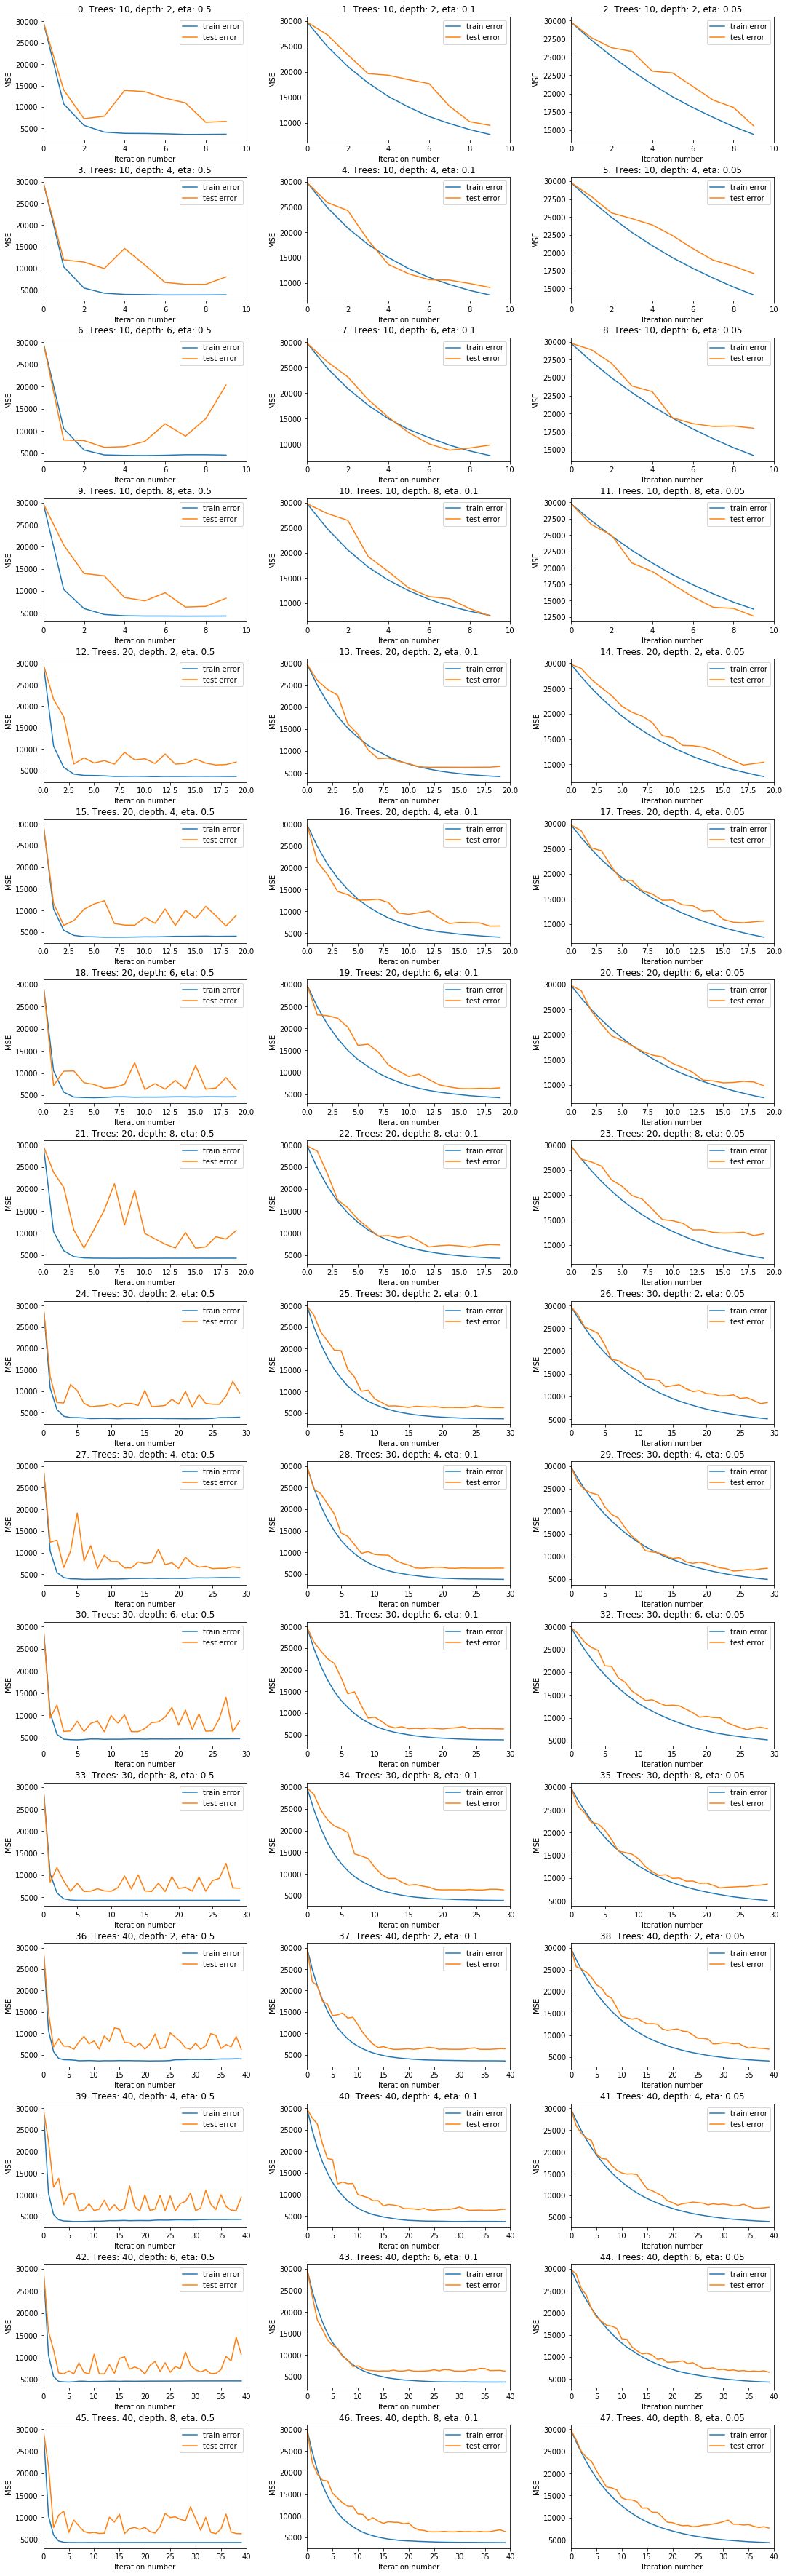

In [82]:
ncols = 3
nrows = (np.prod([len(params[i]) for i in params])) // ncols

fig, ax = plt.subplots(nrows = nrows, ncols = ncols)
fig.set_size_inches(18, 4 * nrows)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

errors = []
axes_counter = 0

for n_trees in params['n_trees']:
    coefs = [1] * n_trees
    for max_depth in params['max_depth']:
        for eta in params['eta']:
            trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
            trees_sgb, train_errors_sgb, test_errors_sgb = sgb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

            __, test_err = evaluate_alg(X_train, X_test, y_train, y_test, trees, coefs, eta)
            __, test_err_sgb = evaluate_alg(X_train, X_test, y_train, y_test, trees_sgb, coefs, eta)
            
            errors.append([n_trees, max_depth, eta, test_err, test_err_sgb])

            err_plot(n_trees, max_depth, eta, test_errors, test_errors_sgb, axes_counter)

            axes_counter +=1

In [83]:
df = pd.DataFrame(errors, columns = ['n_trees', 'max_depth', 'eta', 'test_err', 'test_err_sgb'])
df.loc[df['test_err_sgb'] == df['test_err_sgb'].min()]

,n_trees,max_depth,eta,test_err,test_err_sgb
16,20,4,0.1,3985.344256,6283.187835
